Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


load data

In [2]:
def load_data():
    """
    Load all datasets.
    """
    installs = pd.read_csv('/Users/shahriyar/Desktop/programming/Python/Golden Net/Work/Bonial/dataset/installs.txt', sep='\t')
    app_starts = pd.read_csv('/Users/shahriyar/Desktop/programming/Python/Golden Net/Work/Bonial/dataset/app starts.txt', sep='\t')
    brochure_views = pd.read_csv('/Users/shahriyar/Desktop/programming/Python/Golden Net/Work/Bonial/dataset/brochure views.txt', sep='\t')
    app_starts_july = pd.read_csv('/Users/shahriyar/Desktop/programming/Python/Golden Net/Work/Bonial/dataset/app starts july.txt', sep='\t')
    brochure_views_july = pd.read_csv('/Users/shahriyar/Desktop/programming/Python/Golden Net/Work/Bonial/dataset/brochure views july.txt', sep='\t')

    print("Data Loaded Successfully")
    return installs, app_starts, brochure_views, app_starts_july, brochure_views_july

Exploratory data analysis (EDA)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def eda(**datasets):
 
    for name, data in datasets.items():
        print(f"===== EDA for {name} =====\n")
        
        # 1. Basic Information
        print(f"Shape of {name}: {data.shape}")
        print("\nColumn Information:")
        print(data.info())

        # 2. Missing Values
        print("\nMissing Values per Column:")
        print(data.isnull().sum())

        # 3. Summary Statistics
        print("\nSummary Statistics for Numerical Columns:")
        print(data.describe())

        # 4. First Few Rows
        print("\nFirst 5 Rows of the Dataset:")
        print(data.head())

        print(f"===== End of EDA for {name} =====\n\n")


In [4]:
installs, app_starts, brochure_views, app_starts_july, brochure_views_july = load_data()
    
eda(
    installs=installs,
    brochure_views=brochure_views,
    brochure_views_july=brochure_views_july,
    app_starts=app_starts,
    app_starts_july=app_starts_july
)

Data Loaded Successfully
===== EDA for installs =====

Shape of installs: (20000, 6)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           20000 non-null  int64 
 1   InstallDate  20000 non-null  object
 2   productId    20000 non-null  object
 3   userId       20000 non-null  object
 4   model        19963 non-null  object
 5   campaignId   20000 non-null  object
dtypes: int64(1), object(5)
memory usage: 937.6+ KB
None

Missing Values per Column:
id              0
InstallDate     0
productId       0
userId          0
model          37
campaignId      0
dtype: int64

Summary Statistics for Numerical Columns:
                 id
count  2.000000e+04
mean   3.726129e+07
std    7.106946e+05
min    3.598895e+07
25%    3.665354e+07
50%    3.724843e+07
75%    3.790010e+07
max    3.850684e+07

First 5 Rows of the Dataset:

Preprocess data for training including handling missing values

In [5]:
def preprocess_data(installs, app_starts, brochure_views, app_starts_july, brochure_views_july):
    # Handle Missing Values for Brochure Views
    brochure_views['view_duration'] = brochure_views['view_duration'].fillna(brochure_views['view_duration'].median())
    brochure_views_july['view_duration'].fillna(brochure_views_july['view_duration'].median(), inplace=True)
    installs.dropna(inplace=True)    
    # Convert dates to datetime
    app_starts['dateCreated'] = pd.to_datetime(app_starts['dateCreated'], errors='coerce')
    brochure_views['dateCreated'] = pd.to_datetime(brochure_views['dateCreated'], errors='coerce')
    
    # 2. Missing Values
    print("\n===== Missing Values AFTER Preprocessing =====\n")
    print("Installs Missing Values:\n", installs.isnull().sum())
    print("App Starts Missing Values:\n", app_starts.isnull().sum())
    print("Brochure Views Missing Values:\n", brochure_views.isnull().sum())
    print("App Starts July Missing Values:\n", app_starts_july.isnull().sum())
    print("Brochure Views July Missing Values:\n", brochure_views_july.isnull().sum())

    

    return installs, app_starts, brochure_views, app_starts_july, brochure_views_july

In [6]:
installs, app_starts, brochure_views, app_starts_july, brochure_views_july = preprocess_data(installs, app_starts, brochure_views, app_starts_july, brochure_views_july)
    


===== Missing Values AFTER Preprocessing =====

Installs Missing Values:
 id             0
InstallDate    0
productId      0
userId         0
model          0
campaignId     0
dtype: int64
App Starts Missing Values:
 dateCreated    0
userId         0
dtype: int64
Brochure Views Missing Values:
 id                 0
userId             0
dateCreated        0
page_turn_count    0
view_duration      0
brochure_id        0
dtype: int64
App Starts July Missing Values:
 dateCreated    0
userId         0
dtype: int64
Brochure Views July Missing Values:
 id                 0
userId             0
dateCreated        0
page_turn_count    0
view_duration      0
brochure_id        0
dtype: int64


Features engineering 

In [7]:

def feature_engineering(installs, app_starts, brochure_views, app_starts_july, brochure_views_july):
    # App Starts Features
    app_starts_summary = app_starts.groupby('userId').size().reset_index(name='app_starts_count')
    app_active_days = app_starts.groupby('userId')['dateCreated'].nunique().reset_index(name='app_active_days')

    # Aggregate Brochure Views Features
    brochure_views_summary = brochure_views.groupby('userId').size().reset_index(name='brochure_views_count')
    brochure_engagement = brochure_views.groupby('userId').agg({
        'view_duration': 'sum',
        'page_turn_count': 'sum'
    }).reset_index()

# Calculate average view duration and page turn count
    brochure_engagement['avg_view_duration'] = brochure_engagement['view_duration'] / brochure_views_summary['brochure_views_count']
    brochure_engagement['avg_page_turn_count'] = brochure_engagement['page_turn_count'] / brochure_views_summary['brochure_views_count']

    # Merge Features (LEFT JOIN)
    user_features = app_starts_summary.merge(brochure_views_summary, on='userId', how='left') \
                                    .merge(brochure_engagement, on='userId', how='left') \
                                    .merge(app_active_days, on='userId', how='left')
    # After a left join, the missing values in those columns become NaN because there is no matching record, and Nan means no activity equal 0                                
    user_features.fillna(0, inplace=True)

    #  Add Installs Features
    installs_summary = installs.drop_duplicates(subset='userId') # Remove duplicates installs
    
    le_campaign = LabelEncoder()
    le_model = LabelEncoder()
    le_productid = LabelEncoder()

    installs_summary['campaignId_encoded'] = le_campaign.fit_transform(installs_summary['campaignId'])
    installs_summary['model_encoded'] = le_model.fit_transform(installs_summary['model'])
    installs_summary['productid_encoded'] = le_productid.fit_transform(installs_summary['productId'])

    installs_summary = installs_summary[['userId', 'campaignId_encoded', 'model_encoded', 'productid_encoded']]
    user_features = user_features.merge(installs_summary, on='userId', how='left')
    # Again, after a left join, the missing values in those columns become NaN because there is no matching record, and Nan means no activity equal 0
    user_features.fillna({'campaignId_encoded': 0, 'model_encoded': 0, 'productid_encoded': 0}, inplace=True)

    # Add Target Variable (July Activity)
    july_app_starts = app_starts_july.groupby('userId').size().reset_index(name='july_app_starts_count')
    july_brochure_views = brochure_views_july.groupby('userId').size().reset_index(name='july_brochure_views_count')

    july_activity = july_app_starts.merge(july_brochure_views, on='userId', how='outer').fillna(0)
    july_activity['is_active_july'] = ((july_activity['july_app_starts_count'] > 0) | 
                                    (july_activity['july_brochure_views_count'] > 0)).astype(int)

    final_data = user_features.merge(july_activity[['userId', 'is_active_july']], on='userId', how='left')
    final_data['is_active_july'].fillna(0, inplace=True)

    # Step 6: Save Final Dataset
    final_data.to_csv("final_user_features.csv", index=False)

    print("Feature engineering completed. Final dataset saved!")
    print(final_data.head())
    return final_data

In [8]:
user_features=feature_engineering(installs, app_starts, brochure_views, app_starts_july, brochure_views_july)

Feature engineering completed. Final dataset saved!
                                 userId  app_starts_count  \
0  0000bb01-a52b-4b4c-a0dd-8ef80f0a810c                 1   
1  0002c218-d30f-402e-ae08-1280ad4fb669                 9   
2  000691c6-4289-47f8-81f1-628e52ed5429                 1   
3  00095350-9e64-4b34-9112-b9869703248b                 2   
4  00095653-80f8-4fba-93d9-44ae70bb6263                 4   

   brochure_views_count  view_duration  page_turn_count  avg_view_duration  \
0                   0.0            0.0              0.0                0.0   
1                   0.0            0.0              0.0                0.0   
2                   0.0            0.0              0.0                0.0   
3                   5.0       354315.0            106.0            70863.0   
4                   4.0       142000.0             26.0            35500.0   

   avg_page_turn_count  app_active_days  campaignId_encoded  model_encoded  \
0                  0.0            

In [9]:
user_features.head()

,userId,app_starts_count,brochure_views_count,view_duration,page_turn_count,avg_view_duration,avg_page_turn_count,app_active_days,campaignId_encoded,model_encoded,productid_encoded,is_active_july
0,0000bb01-a52b-4b4c-a0dd-8ef80f0a810c,1,0.0,0.0,0.0,0.0,0.0,1,0.0,439.0,1.0,0.0
1,0002c218-d30f-402e-ae08-1280ad4fb669,9,0.0,0.0,0.0,0.0,0.0,9,0.0,622.0,2.0,0.0
2,000691c6-4289-47f8-81f1-628e52ed5429,1,0.0,0.0,0.0,0.0,0.0,1,0.0,1032.0,1.0,0.0
3,00095350-9e64-4b34-9112-b9869703248b,2,5.0,354315.0,106.0,70863.0,21.2,2,0.0,958.0,0.0,0.0
4,00095653-80f8-4fba-93d9-44ae70bb6263,4,4.0,142000.0,26.0,35500.0,6.5,4,0.0,338.0,0.0,0.0


In [10]:
user_features.isnull().sum()    

userId                  0
app_starts_count        0
brochure_views_count    0
view_duration           0
page_turn_count         0
avg_view_duration       0
avg_page_turn_count     0
app_active_days         0
campaignId_encoded      0
model_encoded           0
productid_encoded       0
is_active_july          0
dtype: int64

In [11]:


def prepare_data(user_features):
    
    # Prepares the dataset by separating features and target,
    X = user_features.drop(columns=['userId', 'is_active_july'])  # Features
    y = user_features['is_active_july']  # Target variable
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    print("Data Preparation Completed.")
    print("Training Set Shape:", X_train.shape)
    print("Testing Set Shape:", X_test.shape)

    return X_train, X_test, y_train, y_test, X.columns



In [12]:
X_train, X_test, y_train, y_test, feature_names = prepare_data(user_features)

Data Preparation Completed.
Training Set Shape: (16058, 10)
Testing Set Shape: (4015, 10)


In [13]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np

def train(model, X_train, X_test, y_train, y_test, cv_splits=5):
    """
    Trains a given model and performs cross validation.
    """
    results = {}

    # Cross-Validation
    print(f"\nPerforming {cv_splits}-Fold Cross-Validation for {model.__class__.__name__}...")
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    cv_mean = np.mean(cv_scores)

    print(f"Cross-Validation Scores: {cv_scores}")
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f"Training Accuracy: {train_accuracy:.4f}")

    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")


    results['model'] = model
    results['cv_mean_accuracy'] = cv_mean
    results['train_accuracy'] = train_accuracy
    results['test_accuracy'] = test_accuracy
    return results


In [14]:
# Random Forest
randomforest_model = RandomForestClassifier(n_estimators=100, random_state=42)
randomforest_results = train(randomforest_model, X_train, X_test, y_train, y_test)

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_results = train(gb_model, X_train, X_test, y_train, y_test)

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_results = train(xgb_model, X_train, X_test, y_train, y_test)

# Display Results
print("\n===== Model Performance Summary =====")
print(f"Random Forest -> CV Accuracy: {randomforest_results['cv_mean_accuracy']:.4f}, "
      f"Train Accuracy: {randomforest_results['train_accuracy']:.4f}, Test Accuracy: {randomforest_results['test_accuracy']:.4f}")

print(f"Gradient Boosting -> CV Accuracy: {gb_results['cv_mean_accuracy']:.4f}, "
      f"Train Accuracy: {gb_results['train_accuracy']:.4f}, Test Accuracy: {gb_results['test_accuracy']:.4f}")

print(f"XGBoost -> CV Accuracy: {xgb_results['cv_mean_accuracy']:.4f}, "
      f"Train Accuracy: {xgb_results['train_accuracy']:.4f}, Test Accuracy: {xgb_results['test_accuracy']:.4f}")


Performing 5-Fold Cross-Validation for RandomForestClassifier...
Cross-Validation Scores: [0.82285181 0.82689913 0.81475716 0.81719091 0.83867954]
Training Accuracy: 0.9602
Test Accuracy: 0.8207

Performing 5-Fold Cross-Validation for GradientBoostingClassifier...
Cross-Validation Scores: [0.84028643 0.8381071  0.82970112 0.82684522 0.85362815]
Training Accuracy: 0.8461
Test Accuracy: 0.8376

Performing 5-Fold Cross-Validation for XGBClassifier...
Cross-Validation Scores: [0.82440847 0.83405978 0.81662516 0.82186235 0.84397384]
Training Accuracy: 0.9086
Test Accuracy: 0.8321

===== Model Performance Summary =====
Random Forest -> CV Accuracy: 0.8241, Train Accuracy: 0.9602, Test Accuracy: 0.8207
Gradient Boosting -> CV Accuracy: 0.8377, Train Accuracy: 0.8461, Test Accuracy: 0.8376
XGBoost -> CV Accuracy: 0.8282, Train Accuracy: 0.9086, Test Accuracy: 0.8321


In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(model, X_test, y_test, feature_names=None):
    """
    Evaluates the trained model on the test set 
    """
    print(f"\n===== Evaluating {model.__class__.__name__} =====")

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTest Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Active', 'Active'], yticklabels=['Not Active', 'Active'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Feature Importance
    feature_importance = model.feature_importances_
    importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importance
        }).sort_values(by='Importance', ascending=False)
    print(importance_df)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.gca().invert_yaxis()
    plt.title(f'Feature Importance ({model.__class__.__name__})')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()
    
    # Model Details
    print("\n===== Model Details =====")
    print(model)




===== Evaluating GradientBoostingClassifier =====

Test Accuracy: 0.8376

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.90      3018
         1.0       0.73      0.56      0.63       997

    accuracy                           0.84      4015
   macro avg       0.79      0.74      0.76      4015
weighted avg       0.83      0.84      0.83      4015

Confusion Matrix:


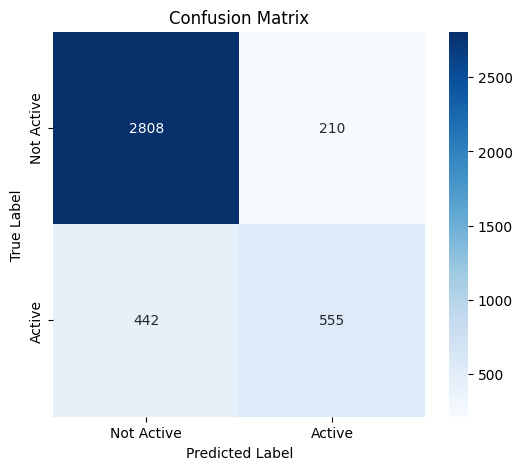

                Feature  Importance
6       app_active_days    0.736651
0      app_starts_count    0.159350
3       page_turn_count    0.030149
8         model_encoded    0.029432
5   avg_page_turn_count    0.011916
7    campaignId_encoded    0.009195
1  brochure_views_count    0.008074
2         view_duration    0.006458
9     productid_encoded    0.004536
4     avg_view_duration    0.004237


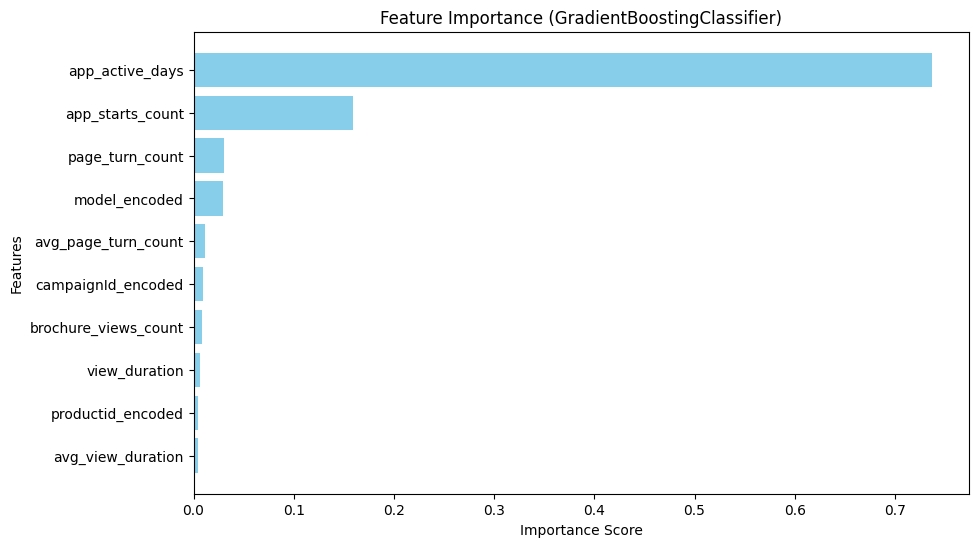


===== Model Details =====
GradientBoostingClassifier(random_state=42)


In [16]:
evaluate_model(gb_model, X_test, y_test, feature_names=feature_names)

In [18]:
y_pred = randomforest_model.predict(X_test)
result_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred,'correct':y_test==y_pred})
    # print(result_df.head())
result_df.head(20)

,Actual,Predicted,correct
14267,1.0,0.0,False
9889,1.0,0.0,False
17226,0.0,0.0,True
1844,0.0,1.0,False
7337,1.0,0.0,False
4467,0.0,0.0,True
19474,0.0,0.0,True
1413,0.0,0.0,True
15481,0.0,0.0,True
1184,0.0,0.0,True
